# DSC530 Week 7 Exercises

Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [3]:
import numpy as np

import random

import thinkstats2
import thinkplot

## Exercise 9-1
As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.

To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use `thinkstats2.SampleRows` to select a random subset of the rows in a DataFrame.

What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

In [5]:
# Generate class to compute the p value based on the mean statistic
class HypothesisTest(object):
    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)
        self.test_stats = None
        self.test_cdf = None

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

    def PValue(self, iters=1000):
        self.test_stats = [self.TestStatistic(self.RunModel()) for _ in range(iters)]
        self.test_cdf = thinkstats2.Cdf(self.test_stats)

        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

In [6]:
# First, let's get the data from the NSFG
import first
live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values

In [7]:
# Checking the number of records
len(data[0]), len(data[1])

(4413, 4735)

In [8]:
# Next let's write a function that takes the data and sample size as input, and returns the power as well as the p value
def power_pval(data, sample_zize = 100):
    import pandas as pd
    # Convert the data to DataFrame because the thinkstats2.SampleRows should be Data frame
    group1, group2 = pd.DataFrame(data[0]), pd.DataFrame(data[1])
    count = 0
    p_value_list = []
    
    for i in range(1000):
        sample1 = thinkstats2.SampleRows(group1, sample_zize)
        sample2 = thinkstats2.SampleRows(group2, sample_zize)
        # Convert the Dataframe back to array for hypothesis testing input in the DiffMeansPermute class instantiation
        # ht = DiffMeansPermute((sample1.values.transpose().flatten(), sample2.values.transpose().flatten()))
        # p_value = ht.PValue(iters=101)
        ht = HypothesisTest((sample1.values.transpose().flatten(), sample2.values.transpose().flatten()))
        p_value = ht.PValue(iters=101)
        if p_value > 0.05:
            count +=1
        p_value_list.append(p_value)
    # Return the power and the mean p value of the iteration
    return (1 - count / 1000), sum(p_value_list) / len(p_value_list)

In [9]:
# Run the function to get power and p value data, increasing sample size by 500 at each run
sample_sz = []
power = []
p_val = []
for nsample in range(100,4401,500):
    pwr, p = power_pval(data, sample_zize = nsample)
    sample_sz.append(nsample)
    power.append(pwr)
    p_val.append(p)

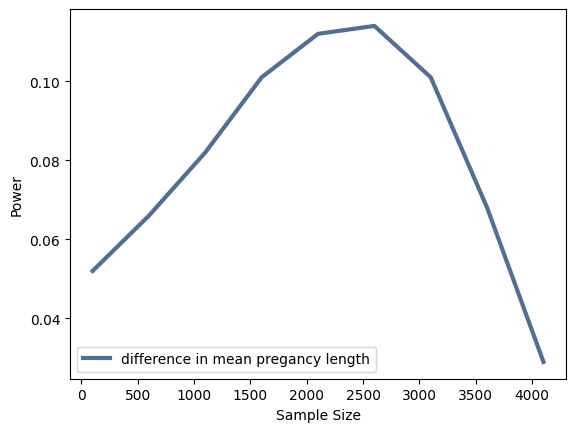

In [10]:
# Draw the plot to visualize the relationship between sample size and power
thinkplot.Plot(sample_sz, power, label = 'difference in mean pregancy length')
thinkplot.Config(xlabel='Sample Size', ylabel='Power')

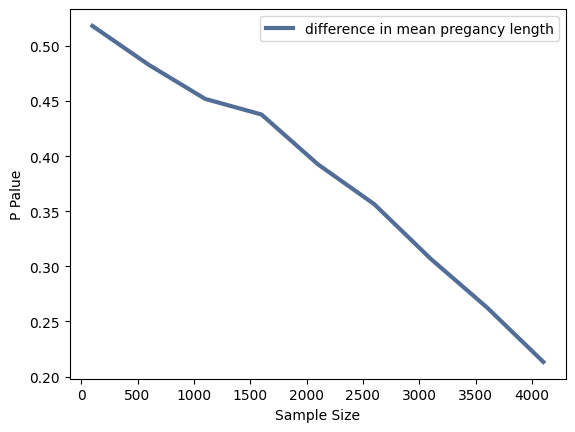

In [11]:
# Draw the plot to visualize the relationship between sample size and p_value
thinkplot.Plot(sample_sz, p_val, label = 'difference in mean pregancy length')
thinkplot.Config(xlabel='Sample Size', ylabel='P Palue')

The power does seem to increase when the sample size increases, but not alway the case as it starts to fall as the sample size approximates the population data (although it's a sampling data from the world population, in this case it's a population). The p value and sample size demonstrates inverse relationship.

## Exercise 10-1
Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

Read the BRFSS data and extract heights and log weights.

In [15]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")

In [16]:
import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

Estimate intercept and slope.

In [18]:
# Define the LeastSquares function using helper functions from thinkstats2
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)

    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx

    return inter, slope

In [19]:
# Estimatation
inter, slope = LeastSquares(heights, log_weights)
inter, slope

(0.9930804163932916, 0.005281454169417754)

Make a scatter plot of the data and show the fitted line.

In [21]:
# Define the fit line function
def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

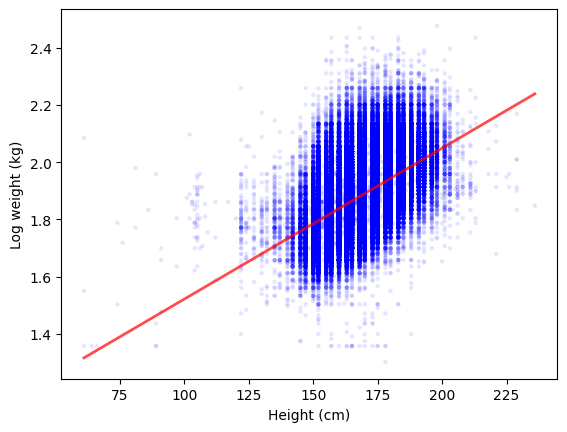

In [22]:
# Make the scatter plot
fit_xs, fit_ys = FitLine(heights, inter, slope)

thinkplot.Scatter(heights, log_weights, color='blue', alpha=0.1, s=10)
thinkplot.Plot(fit_xs, fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="Height (cm)",
                 ylabel='Log weight (kg)',
                 legend=False)

Make the same plot but apply the inverse transform to show weights on a linear (not log) scale.

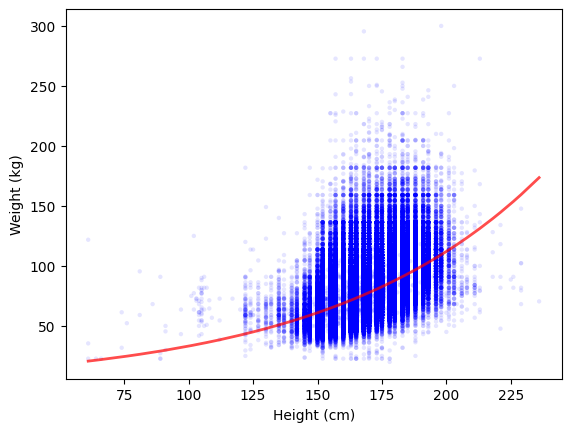

In [24]:
thinkplot.Scatter(heights, weights, color='blue', alpha=0.1, s=10)
thinkplot.Plot(fit_xs, 10**(fit_ys), color='red', linewidth=2)
thinkplot.Config(xlabel="Height (cm)",
                 ylabel='Weight (kg)',
                 legend=False)

Plot percentiles of the residuals.

In [26]:
# Define function to compute the residuals
def Residuals(xs, ys, inter, slope):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res

In [27]:
# Add the residuals to the df
df['residual'] = Residuals(heights, log_weights, inter, slope)

In [28]:
# Check the range of the heights
min(heights), max(heights)

(61.0, 236.0)

In [29]:
# Make the groups and compute the average heights in each group, and compute the CDF of the residuals in each group
bins = np.arange(60, 241, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

height_means = [group.htm3.mean() for _, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.residual) for _, group in groups][1:-1]

In [30]:
# Define function to plot percentiles of the residuals against the average age in each group
def PlotPercentiles(height_means, cdfs):
    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        log_weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(height_means, log_weight_percentiles, label=label)
    thinkplot.Config(xlabel="Mothers' Height (cm)",
                 ylabel='Residual of log weights(kg)',
                 xlim=[60, 240])

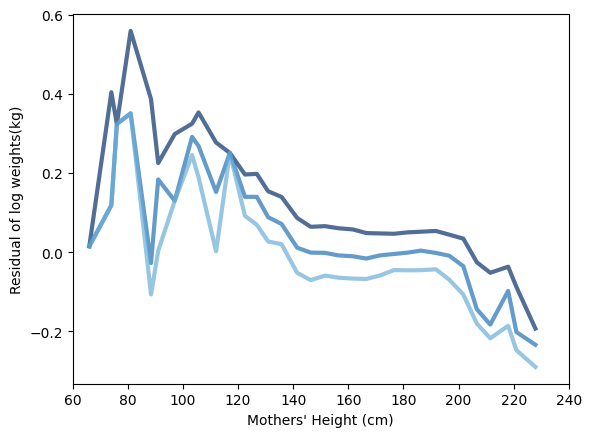

In [31]:
# Draw the residual percentile plot
PlotPercentiles(height_means, cdfs)

The residuals are about the same between 140 and 200 cm, which is the normal range of women's height, and the lines are parallel, meanning the relationship is linear and variance consistent among that range.

Compute correlation.

In [34]:
print(thinkstats2.Corr(heights, log_weights))

0.5317282605983414


Compute coefficient of determination.

In [36]:
# Define r^2
def CoefDetermination(ys, res):
    return 1 - Var(res) / Var(ys)

In [37]:
# Compuet the r^2 
r2 = CoefDetermination(log_weights, df.residual)
r2

0.28273494311893965

Confirm that $R^2 = \rho^2$.

In [39]:
thinkstats2.Corr(heights, log_weights)**2

0.2827349431189377

According to the results above, square of correlation is equal to the r^2

Compute Std(ys), which is the RMSE of predictions that don't use height.

In [42]:
Std(log_weights)

0.10320725030004888

Compute Std(res), the RMSE of predictions that do use height.

In [44]:
Std(df.residual)

0.08740777080416086

How much does height information reduce RMSE?

In [46]:
(Std(log_weights) -  Std(df.residual)) / Std(log_weights)

0.1530849765879339

A reduction of about 15%

Use resampling to compute sampling distributions for inter and slope.

In [49]:
# Define resampling
def SampleRows(df, nrows, replace=False):
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

def ResampleRows(df):
    return SampleRows(df, len(df), replace=True)

In [50]:
# Define function to get the sampling distribution
def SamplingDistributions(df, iters=101):
    t = []
    for _ in range(iters):
        sample = ResampleRows(df)
        heights = sample.htm3
        log_weights = np.log10(sample.wtkg2)
        estimates = LeastSquares(heights, log_weights)
        t.append(estimates)

    inters, slopes = zip(*t)
    return inters, slopes

In [51]:
# Compute the sampling distribution for inter and slope
inters, slopes = SamplingDistributions(df, iters = 1001)

Plot the sampling distribution of slope.

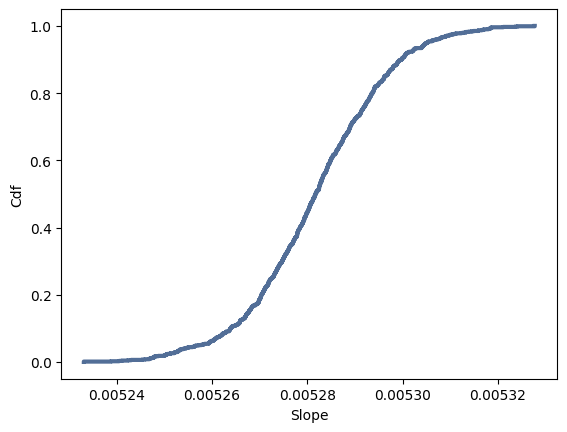

In [53]:
cdf_slope = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf_slope)
thinkplot.Config(xlabel = 'Slope', ylabel = 'Cdf')

Compute the p-value of the slope.

In [55]:
# Use the Hypothesis test class we defined above to calculate the p-value using the mean diff as test statistic
# Technically I think this class should be fine as we are comparing the mean of the slope we calculated, which is the slope itself, and the resampled
# slopes after 1001 iterations, where the calculated slope and the resampled slopes will be reshuffled in the Runmodel funciton. 

slope_array = np.array([slope])
slopes_array = np.array(slopes)
ht_slopes = HypothesisTest((slope_array, slopes_array))
p_value_slopes = ht_slopes.PValue(iters=101)
p_value_slopes

0.9801980198019802

Compute the 90% confidence interval of slope.

In [57]:
cdf_slope.ConfidenceInterval(90)

(0.00525772232728413, 0.0053050567639995674)

Compute the mean of the sampling distribution.

In [59]:
thinkstats2.Mean(inters), thinkstats2.Mean(slopes)

(0.9930148361414448, 0.005281818166819183)

Compute the standard deviation of the sampling distribution, which is the standard error.

In [61]:
thinkstats2.Std(inters), thinkstats2.Std(slopes)

(0.0024536464733567855, 1.4389879722418656e-05)

Resample rows without weights, compute mean height, and summarize results.

In [63]:
# Define the summary funciton
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('Mean:', mean, 'SE:', stderr, 'CI:',ci)

In [64]:
# Reamples rows without weights and get summary of mean height
Summarize([ResampleRows(df.htm3).mean() for i in range(100)])

Mean: 168.95564830534167 SE: 0.017092631519521062 CI: (168.92649912083914, 168.9842003678328)


Resample rows with weights.  Note that the weight column in this dataset is called `finalwt`.

In [66]:
# Define resampling function with weight
def ResampleRowsWeighted(df, column='finalwt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

In [67]:
# Reamples rows with weights and get summary of mean height
Summarize([ResampleRowsWeighted(df).htm3.mean() for i in range(100)])

Mean: 170.4972066937488 SE: 0.014368627823606964 CI: (170.47370096404535, 170.5192253279169)
